In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time

In [245]:
def I_Ca(m_Ca, V_m, Ca_in):
    P_max = 0.006
    Ca_out = 2.1
    T = 293.1
    F = 96.4853365
    R = 8.3144626

    #OG functions
    top = Ca_in - Ca_out * np.exp((-2 * F * V_m) / (R * T))
    bottom = 1 - np.exp((-2 * F * V_m) / (R * T))

    #But we approximate with a step function for numeric reasons
    #aprox = 2.1 if V_m < 0 else Ca_in
    
    before = (m_Ca ** 2) * P_max * V_m

    #return before * aprox
    return before * (top / bottom)

def I_K(m_K, V_m):
    G_K = 9.75
    E_K = -81

    return G_K * (m_K ** 3) * (V_m - E_K)

def delta_m_x(alpha, beta, V_m, m_x):
    return alpha(V_m) * (1 - m_x) - beta(V_m) * m_x

In [246]:
# Calcium and Potassium gates
def alpha_K(V_m):
    a = 1
    b = 1
    c = 1

    return c / (1 + np.exp(-a * V_m + b))

def beta_K(V_m):
    a = 1
    b = 1
    c = 1

    return c / (1 + np.exp(-a * V_m + b))

def alpha_Ca(V_m):
    a = 1
    b = -75
    c = 30

    return c / (1 + np.exp(-a * V_m + b))

def beta_Ca(V_m):
    a = 1
    b = 1
    c = 1

    return c / (1 + np.exp(-a * V_m + b))

In [247]:
#calcium-gated potassium channel
def I_SK(m_SK, V_m):
    G_SK = 0.2125
    E_SK = -81

    return G_SK * m_SK * (V_m - E_SK)

def m_inf(Ca_in):
    K_SK = 0.4
    return Ca_in / (Ca_in + K_SK)

def tau_m(Ca_in):
    K_SK = 0.4
    phi_SK = 2.8
    return phi_SK / (Ca_in + K_SK)

def delta_m_SK(Ca_in, m_SK):
    return (m_inf(Ca_in) - m_SK) / tau_m(Ca_in)

In [248]:
# Leakage

def I_leak(V_m):
    G_leak = 0.0525
    E_leak = -74

    return G_leak * (V_m - E_leak)

In [249]:
# Calcium Level

def delta_Ca_in(Ca_in, I_Ca, CaB):
    k_f = 0.1
    k_b = 0.3
    G_pump = 3.6
    K_pump = 0.75
    B = 30
    F = 96485.3365 #Assuming faraday constant again
    # This is diffusion length and is not provided but probably doesn't matter because the first term will be close to 0
    d_len = 1 

    return (-1 / (2 * F * d_len)) * I_Ca + k_b * B * CaB - k_f * Ca_in * B * (1 - CaB) - (G_pump * Ca_in)/(Ca_in + K_pump)

def delta_CaB(Ca_in, CaB):
    k_f = 0.1
    k_b = 0.3

    return -k_b * CaB + k_f * Ca_in * (1 - CaB)

In [250]:
# Voltage

def delta_V_m(I_K, I_Ca, I_SK, I_leak, I_in):
    C_m = 38.5

    current_sum = -(I_K + I_Ca + I_SK + I_leak) + I_in
    return current_sum / C_m

In [251]:
#Fluorescence

def fluorescence(Ca_in):

    K_YC = 250
    rho = 1.7
    R_max = 9.3
    R_min = 1.4
    
    phi = (Ca_in / K_YC) ** rho
    return (phi * R_max + R_min) / (1 + phi)

In [252]:
def start_sim(time_step = 0.0001, run_time=2.0):
    input_current = 0
    
    # Set inital values
    V_m = -70
    m_K = 0
    m_Ca = 0
    m_SK = 0
    Ca_in = 50
    CaB = 1
    t = 0

    # Storage
    V_m_array = []
    m_K_array = []
    m_Ca_array = []
    m_SK_array = []
    Ca_in_array = []
    CaB_array = []
    I_SK_array = []
    I_Ca_array = []
    I_K_array = []
    time = []

    time_range = int(run_time / time_step)
    for i in range(time_range):
        if i == time_range // 4:
            print("25%")
        if i == time_range // 2:
            input_current = 50
            print("50%")
        if i == (time_range // 4) * 3:
            input_current = 0
            print("75%")

        # Time stuff
        time.append(t)
        t += time_step
        
        # Calculate deltas
        Ca_current = I_Ca(m_Ca, V_m, Ca_in)
        K_current = I_K(m_K, V_m)
        SK_current = I_SK(m_SK, V_m)
        
        d_V_m = delta_V_m(K_current, Ca_current, SK_current, I_leak(V_m), input_current)
        d_m_K = delta_m_x(alpha_K, beta_K, V_m, m_K)
        d_m_Ca = delta_m_x(alpha_Ca, beta_Ca, V_m, m_Ca)
        d_m_SK = delta_m_SK(Ca_in, m_SK)
        d_Ca_in = delta_Ca_in(Ca_in, Ca_current, CaB)
        d_CaB = delta_CaB(Ca_in, CaB)
    
        #Update
        V_m += d_V_m * time_step
        m_K += d_m_K * time_step
        m_Ca += d_m_Ca * time_step
        m_SK += d_m_SK * time_step
        Ca_in += d_Ca_in * time_step
        CaB += d_CaB * time_step
    
        #Store
        V_m_array.append(V_m)
        m_K_array.append(m_K)
        m_Ca_array.append(m_Ca)
        m_SK_array.append(m_SK)
        Ca_in_array.append(Ca_in)
        CaB_array.append(CaB)
        I_SK_array.append(SK_current)
        I_Ca_array.append(Ca_current)
        I_K_array.append(K_current)

    return [V_m_array, m_K_array, m_Ca_array, m_SK_array, Ca_in_array, CaB_array, time, I_SK_array, I_Ca_array, I_K_array]

In [253]:
def to_z_score(x):
    return (x - np.mean(x)) / np.std(x)

25%
50%
75%


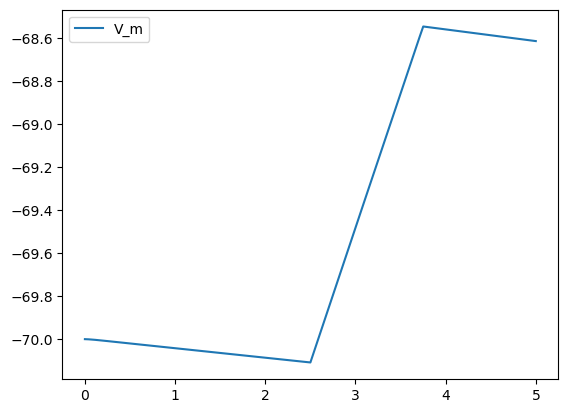

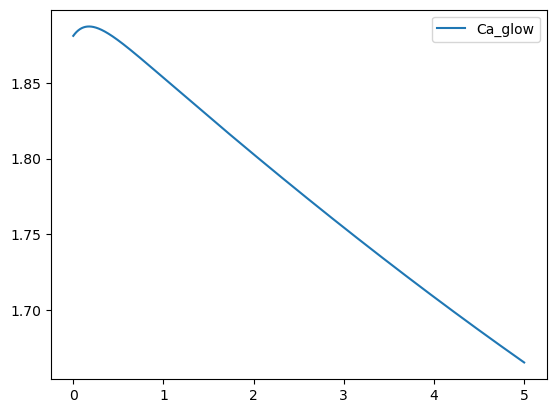

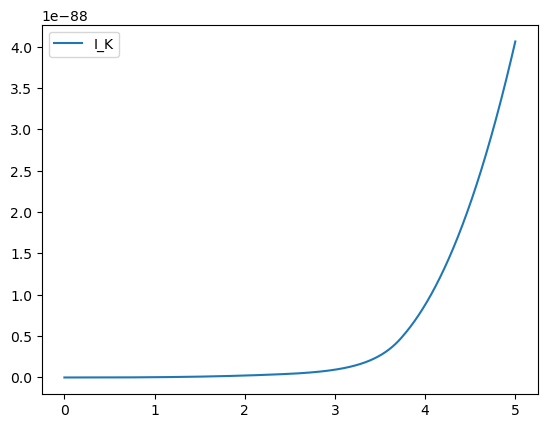

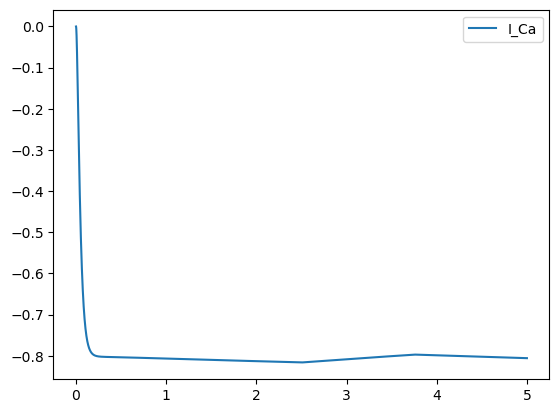

In [254]:
delta_ts = [0.0001]

for delta in delta_ts:
    result = start_sim(delta, 5.0)
    
    norm_v = to_z_score(result[0])
    norm_Ca = to_z_score(result[4])

    Ca = np.array(result[4])

    glow = fluorescence(Ca)

    
    plt.plot(result[6][::10], result[0][::10], label='V_m')
    plt.legend(loc='best')
    plt.show()
    plt.plot(result[6][::10], glow[::10], label='Ca_glow')
    plt.legend(loc='best')
    plt.show()
    plt.plot(result[6][::10], result[9][::10], label='I_K')
    plt.legend(loc='best')
    plt.show()
    plt.plot(result[6][::10], result[8][::10], label='I_Ca')
    plt.legend(loc='best')
    plt.show()
    